In [0]:
#General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Keras imports
import keras

from keras.preprocessing.image import load_img
from keras.models import Sequential, Model, Input
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
import keras.backend as K

# application (model) imports
from keras import applications
#from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import confusion_matrix
import csv
import cv2

Using TensorFlow backend.


In [0]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))
    plt.xlabel('Number of Epochs')

In [0]:
import requests, zipfile, io, pickle

r = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))

train = pickle.load(z.open('train.p'))
test = pickle.load(z.open('test.p'))

In [0]:
X_train, Y_train = train['features'], train['labels']
X_test, Y_test = test['features'], test['labels']
n_classes = len(np.unique(Y_train))

print("Number of train samples: ", X_train.shape[0])
print("Number of test samples: ", X_test.shape[0])
print("Number of classses: ", n_classes)

Number of train samples:  34799
Number of test samples:  12630
Number of classses:  43


In [0]:
def show_hist(data, label):
  plt.hist(data, bins = n_classes)
  plt.xlabel(label)
  plt.ylabel('class count')
  plt.grid('off')
  plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


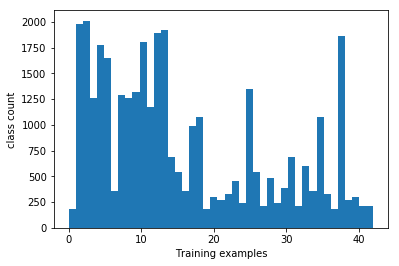

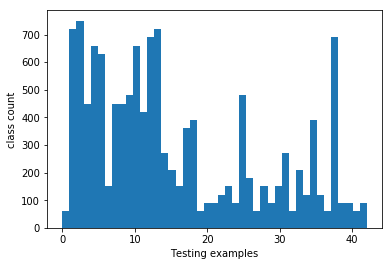

In [0]:
show_hist(Y_train, "Training examples")
show_hist(Y_test, "Testing examples")

In [0]:
X_train, Y_train = shuffle(X_train, Y_train)

In [0]:
import skimage.morphology as morp
from skimage.filters import rank

In [0]:
def convert_to_gray(image):
  
  return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [0]:
gray_images = list(map(convert_to_gray,X_train))
np.shape(gray_images)

(34799, 32, 32)

In [0]:
def hist_equalization(image):
  kernel = morp.disk(30)
  return rank.equalize(image, selem=kernel)

In [0]:
def adapt_hist_equalization(image,clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))):
  return clahe.apply(image)

In [0]:

equalizied_gray_images = list(map(hist_equalization,gray_images))

In [0]:
def norm_image(data):
  
  normalized_images = np.array(data,dtype = np.float32)/255
  return np.expand_dims(normalized_images, axis=-1)

In [0]:
def preprocess(x_data,y_data, n_classes = 43):
  gray_images = list(map(convert_to_gray,x_data))
  hist_equal_images = list(map(adapt_hist_equalization,gray_images))
  norm_images = norm_image(hist_equal_images)
  y_data = to_categorical(y_data, n_classes)
  return norm_images, y_data 

In [0]:
X_train_processed, Y_train_cat = preprocess(X_train,Y_train)
class_weights = compute_class_weight('balanced',classes = np.unique(Y_train),y = Y_train)

In [0]:
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten
from keras.initializers import random_normal
from keras import optimizers

In [0]:
image_size = (X_train_processed.shape[1], X_train_processed.shape[2],X_train_processed.shape[3])
image_vector_size = image_size[0] * image_size[1]* image_size[2]

In [0]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=n_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_2 (Dense)              (None, 43)                1419      
Total params: 34,219
Trainable params: 34,219
Non-trainable params: 0
_________________________________________________________________


In [0]:
plot_model(model,to_file='model.png')

NameError: ignored

In [0]:
X_test_processed, Y_test_cat = preprocess(X_test, Y_test)

In [0]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
x_train = X_train_processed.reshape(X_train_processed.shape[0], image_vector_size) /255.
x_test = X_test_processed.reshape(X_test_processed.shape[0], image_vector_size) /255.

In [0]:
history = model.fit(x_train, Y_train_cat, batch_size=256, epochs=10, verbose=True, validation_split=.2,class_weight = class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 27839 samples, validate on 6960 samples
Epoch 1/10





27839/27839 [==============================] - 1s 40us/step - loss: 3.7551 - acc: 0.0571 - val_loss: 3.6976 - val_acc: 0.0560
Epoch 2/10
27839/27839 [==============================] - 0s 16us/step - loss: 3.6489 - acc: 0.0571 - val_loss: 3.6162 - val_acc: 0.0560
Epoch 3/10
27839/27839 [==============================] - 0s 16us/step - loss: 3.5856 - acc: 0.0571 - val_loss: 3.5677 - val_acc: 0.0560
Epoch 4/10
27839/27839 [==============================] - 0s 16us/step - loss: 3.5477 - acc: 0.0571 - val_loss: 3.5383 - val_acc: 0.0560
Epoch 5/10
27839/27839 [==============================] - 0s 16us/step - loss: 3.5245 - acc: 0.0571 - val_loss: 3.5201 - val_acc: 0.0560
Epoch 6/10
27839/27839 [==============================] - 0s 16us/step - loss: 3.5098 - acc: 0.0571 - val_loss: 3.5085 - val_acc: 0.0560
Epoch 7/10
27839/27839 [===

Test loss: 3.47
Test accuracy: 0.057


<Figure size 576x432 with 0 Axes>

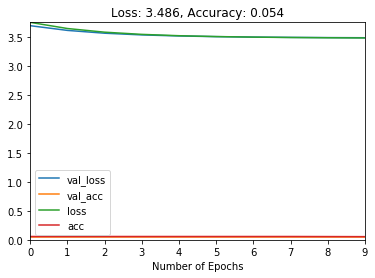

In [0]:
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=1024, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=n_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 43)                44075     
Total params: 1,093,675
Trainable params: 1,093,675
Non-trainable params: 0
_________________________________________________________________


In [0]:
plot_model(model,to_file='model.png')

NameError: ignored

In [0]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, Y_train_cat, batch_size=1, epochs=10, verbose=True, validation_split=.2,class_weight = class_weights)
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 27839 samples, validate on 6960 samples
Epoch 1/10





27839/27839 [==============================] - 238s 9ms/step - loss: 4.1604 - acc: 0.0428 - val_loss: 4.1462 - val_acc: 0.0216
Epoch 2/10
27839/27839 [==============================] - 238s 9ms/step - loss: 4.2032 - acc: 0.0405 - val_loss: 4.3083 - val_acc: 0.0384
Epoch 3/10
27839/27839 [==============================] - 241s 9ms/step - loss: 4.2581 - acc: 0.0418 - val_loss: 4.4775 - val_acc: 0.0384
Epoch 4/10
27839/27839 [==============================] - 236s 8ms/step - loss: 4.3224 - acc: 0.0408 - val_loss: 4.0953 - val_acc: 0.0289
Epoch 5/10
27839/27839 [==============================] - 230s 8ms/step - loss: 4.3764 - acc: 0.0409 - val_loss: 4.4801 - val_acc: 0.0345
Epoch 6/10
27839/27839 [==============================] - 234s 8ms/step - loss: 4.4451 - acc: 0.0405 - val_loss: 4.0531 - val_acc: 0.0384
Epoch 7/10
27839/2783

In [0]:
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)

Test loss: 4.87
Test accuracy: 0.0166


<Figure size 576x432 with 0 Axes>

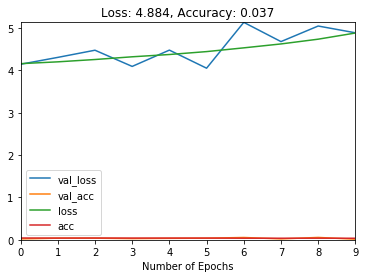

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=1024, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=n_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_24 (Dense)             (None, 43)                44075     
Total params: 1,093,675
Trainable params: 1,093,675
Non-trainable params: 0
_________________________________________________________________


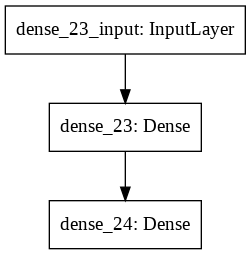

In [0]:
plot_model(model,to_file='model.png')

In [0]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, Y_train_cat, batch_size=256, epochs=50, verbose=True, validation_split=.2,class_weight = weights)

Train on 27839 samples, validate on 6960 samples
Epoch 1/50
27839/27839 [==============================] - 5s 188us/step - loss: 6.6919 - acc: 0.0546 - val_loss: 6.5639 - val_acc: 0.0555
Epoch 2/50
27839/27839 [==============================] - 4s 145us/step - loss: 6.5393 - acc: 0.0551 - val_loss: 6.5117 - val_acc: 0.0555
Epoch 3/50
27839/27839 [==============================] - 4s 145us/step - loss: 6.5012 - acc: 0.0551 - val_loss: 6.4844 - val_acc: 0.0555
Epoch 4/50
27839/27839 [==============================] - 4s 146us/step - loss: 6.4789 - acc: 0.0551 - val_loss: 6.4666 - val_acc: 0.0555
Epoch 5/50
27839/27839 [==============================] - 4s 146us/step - loss: 6.4636 - acc: 0.0551 - val_loss: 6.4536 - val_acc: 0.0555
Epoch 6/50
27839/27839 [==============================] - 4s 150us/step - loss: 6.4521 - acc: 0.0551 - val_loss: 6.4437 - val_acc: 0.0555
Epoch 7/50
27839/27839 [==============================] - 4s 150us/step - loss: 6.4432 - acc: 0.0551 - val_loss: 6.4357 - v

In [0]:
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)

Test loss: 6.39
Test accuracy: 0.0549


<Figure size 576x432 with 0 Axes>

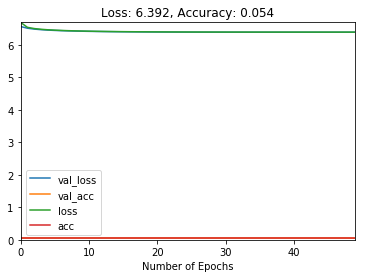

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:

def build_basic_model():
  model = Sequential()

  model.add(Dense(units=1024, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dense(units=n_classes, activation='softmax'))
  return model


In [0]:
model = build_basic_model()
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_26 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_27 (Dense)             (None, 43)                11051     
Total params: 1,323,051
Trainable params: 1,323,051
Non-trainable params: 0
_________________________________________________________________


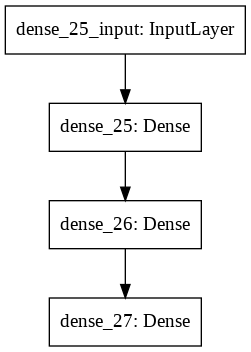

In [0]:
plot_model(model,to_file='model.png')

In [0]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
history = model.fit(x_train, Y_train_cat, batch_size=256, epochs=50, verbose=True, validation_split=.2,class_weight = weights)

Train on 27839 samples, validate on 6960 samples
Epoch 1/50
27839/27839 [==============================] - 7s 254us/step - loss: 3.4838 - acc: 0.0742 - val_loss: 3.3671 - val_acc: 0.1009
Epoch 2/50
27839/27839 [==============================] - 6s 216us/step - loss: 3.1934 - acc: 0.1405 - val_loss: 2.9855 - val_acc: 0.1989
Epoch 3/50
27839/27839 [==============================] - 6s 212us/step - loss: 2.6731 - acc: 0.2544 - val_loss: 2.3920 - val_acc: 0.3240
Epoch 4/50
27839/27839 [==============================] - 6s 210us/step - loss: 2.1779 - acc: 0.3684 - val_loss: 2.0105 - val_acc: 0.4162
Epoch 5/50
27839/27839 [==============================] - 6s 213us/step - loss: 1.8600 - acc: 0.4457 - val_loss: 1.7522 - val_acc: 0.4846
Epoch 6/50
27839/27839 [==============================] - 6s 214us/step - loss: 1.6441 - acc: 0.5062 - val_loss: 1.5759 - val_acc: 0.5445
Epoch 7/50
27839/27839 [==============================] - 6s 219us/step - loss: 1.4785 - acc: 0.5595 - val_loss: 1.4381 - v

In [0]:
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)

Test loss: 0.83
Test accuracy: 0.81


<Figure size 576x432 with 0 Axes>

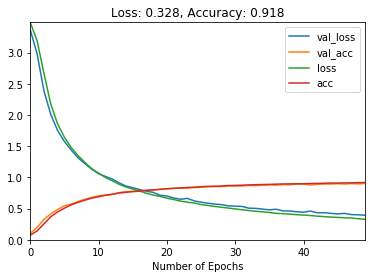

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=1024, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dense(units=n_classes, activation='softmax'))
  return model

In [0]:
model = build_basic_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_29 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_30 (Dense)             (None, 43)                11051     
Total params: 1,323,051
Trainable params: 1,323,051
Non-trainable params: 0
_________________________________________________________________


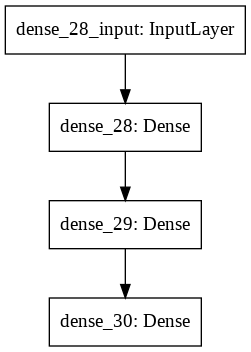

In [0]:
plot_model(model,to_file='model.png')

In [0]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, Y_train_cat, batch_size=256, epochs=150, verbose=True, validation_split=.2,class_weight = weights)

Train on 27839 samples, validate on 6960 samples
Epoch 1/150
27839/27839 [==============================] - 7s 268us/step - loss: 3.6755 - acc: 0.0576 - val_loss: 3.5166 - val_acc: 0.0586
Epoch 2/150
27839/27839 [==============================] - 6s 198us/step - loss: 3.4832 - acc: 0.0609 - val_loss: 3.4697 - val_acc: 0.0731
Epoch 3/150
27839/27839 [==============================] - 6s 201us/step - loss: 3.4516 - acc: 0.0733 - val_loss: 3.4363 - val_acc: 0.0968
Epoch 4/150
27839/27839 [==============================] - 6s 204us/step - loss: 3.4078 - acc: 0.1045 - val_loss: 3.3872 - val_acc: 0.1214
Epoch 5/150
27839/27839 [==============================] - 6s 202us/step - loss: 3.3548 - acc: 0.1207 - val_loss: 3.3358 - val_acc: 0.1180
Epoch 6/150
27839/27839 [==============================] - 6s 200us/step - loss: 3.3010 - acc: 0.1241 - val_loss: 3.2851 - val_acc: 0.1267
Epoch 7/150
27839/27839 [==============================] - 6s 201us/step - loss: 3.2480 - acc: 0.1311 - val_loss: 3.2

In [0]:
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)

Test loss: 0.937
Test accuracy: 0.751


<Figure size 576x432 with 0 Axes>

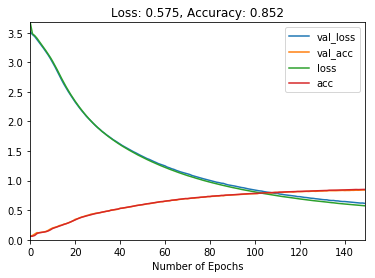

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten

In [0]:
def build_deeper_model():
  model = Sequential()
  model.add(Dense(units=1024, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units=n_classes, activation='softmax'))
  return model
model = build_deeper_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_35 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 43)                11051     
Total params: 1,323,051
Trainable params: 1,323,051
Non-trainable params: 0
_________________________________________________________________


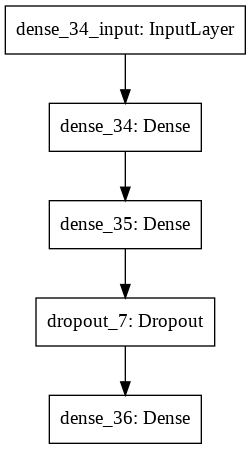

In [0]:
plot_model(model,to_file='model.png')

In [0]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, Y_train_cat, batch_size=256, epochs=50, verbose=True, validation_split=.2,class_weight = weights)

Train on 27839 samples, validate on 6960 samples
Epoch 1/50
27839/27839 [==============================] - 8s 280us/step - loss: 3.4885 - acc: 0.0679 - val_loss: 3.3730 - val_acc: 0.1073
Epoch 2/50
27839/27839 [==============================] - 6s 230us/step - loss: 3.1868 - acc: 0.1334 - val_loss: 2.9981 - val_acc: 0.1858
Epoch 3/50
27839/27839 [==============================] - 6s 215us/step - loss: 2.7216 - acc: 0.2269 - val_loss: 2.4938 - val_acc: 0.2981
Epoch 4/50
27839/27839 [==============================] - 6s 214us/step - loss: 2.2845 - acc: 0.3348 - val_loss: 2.1293 - val_acc: 0.3872
Epoch 5/50
27839/27839 [==============================] - 6s 215us/step - loss: 1.9566 - acc: 0.4285 - val_loss: 1.8495 - val_acc: 0.4471
Epoch 6/50
27839/27839 [==============================] - 6s 215us/step - loss: 1.7117 - acc: 0.4921 - val_loss: 1.6256 - val_acc: 0.5237
Epoch 7/50
27839/27839 [==============================] - 6s 209us/step - loss: 1.5367 - acc: 0.5392 - val_loss: 1.4893 - v

Test loss: 0.827
Test accuracy: 0.81


<Figure size 576x432 with 0 Axes>

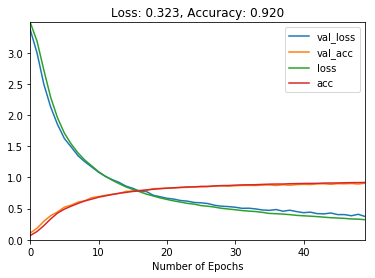

In [0]:
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_deeper_model():
  model = Sequential()
  model.add(Dense(units=1024, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(units=n_classes, activation='softmax'))
  return model
model = build_deeper_model()
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_38 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_40 (Dense)             (None, 43)                5547      
Total params: 1,350,443
Trainable params: 1,350,443
Non-trainable params: 0
_________________________________________________________________


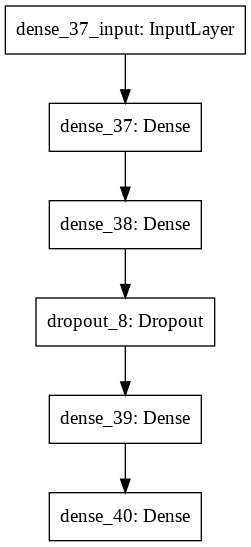

In [0]:
plot_model(model,to_file='model.png')

In [0]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, Y_train_cat, batch_size=256, epochs=50, verbose=True, validation_split=.2,class_weight = class_weights)

Train on 27839 samples, validate on 6960 samples
Epoch 1/50
27839/27839 [==============================] - 8s 290us/step - loss: 3.5093 - acc: 0.0653 - val_loss: 3.3776 - val_acc: 0.0973
Epoch 2/50
27839/27839 [==============================] - 7s 241us/step - loss: 3.1298 - acc: 0.1411 - val_loss: 2.7003 - val_acc: 0.2136
Epoch 3/50
27839/27839 [==============================] - 7s 245us/step - loss: 2.4581 - acc: 0.2613 - val_loss: 2.2103 - val_acc: 0.3269
Epoch 4/50
27839/27839 [==============================] - 7s 252us/step - loss: 2.0668 - acc: 0.3657 - val_loss: 1.8556 - val_acc: 0.4366
Epoch 5/50
27839/27839 [==============================] - 7s 248us/step - loss: 1.7648 - acc: 0.4505 - val_loss: 1.5751 - val_acc: 0.5292
Epoch 6/50
27839/27839 [==============================] - 7s 244us/step - loss: 1.5601 - acc: 0.5115 - val_loss: 1.4023 - val_acc: 0.5911
Epoch 7/50
27839/27839 [==============================] - 7s 247us/step - loss: 1.4092 - acc: 0.5593 - val_loss: 1.2470 - v

Test loss: 0.784
Test accuracy: 0.826


<Figure size 576x432 with 0 Axes>

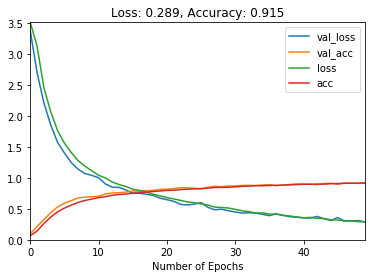

In [0]:
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_deeper_model():
  model = Sequential()
  model.add(Dense(units=1024, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units=128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units=n_classes, activation='softmax'))
  return model
model = build_deeper_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_16 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 43)                5547      
Total params: 1,350,443
Trainable params: 1,350,443
Non-trainable params: 0
____________________________________________

In [0]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, Y_train_cat, batch_size=256, epochs=50, verbose=True, validation_split=.2,class_weight = class_weights)

Train on 27839 samples, validate on 6960 samples
Epoch 1/50
27839/27839 [==============================] - 8s 283us/step - loss: 3.5238 - acc: 0.0599 - val_loss: 3.3676 - val_acc: 0.0885
Epoch 2/50
27839/27839 [==============================] - 7s 260us/step - loss: 3.2051 - acc: 0.1167 - val_loss: 2.8439 - val_acc: 0.1886
Epoch 3/50
27839/27839 [==============================] - 7s 248us/step - loss: 2.6141 - acc: 0.2190 - val_loss: 2.3091 - val_acc: 0.2784
Epoch 4/50
27839/27839 [==============================] - 7s 251us/step - loss: 2.3039 - acc: 0.2793 - val_loss: 2.0719 - val_acc: 0.3365
Epoch 5/50
27839/27839 [==============================] - 7s 248us/step - loss: 2.1150 - acc: 0.3302 - val_loss: 1.8863 - val_acc: 0.4082
Epoch 6/50
27839/27839 [==============================] - 7s 249us/step - loss: 1.9378 - acc: 0.3809 - val_loss: 1.7822 - val_acc: 0.4411
Epoch 7/50
27839/27839 [==============================] - 7s 256us/step - loss: 1.7866 - acc: 0.4308 - val_loss: 1.6127 - v

Test loss: 0.735
Test accuracy: 0.828


<Figure size 576x432 with 0 Axes>

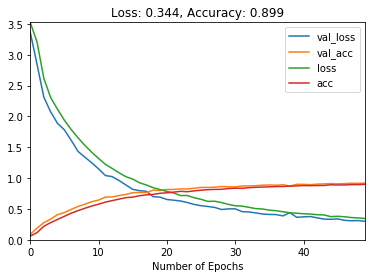

In [0]:
loss, accuracy  = model.evaluate(x_test, Y_test_cat, verbose=False)
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_convnet():
  model = Sequential()
  
  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape = image_size))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))

  model.add(Dense(n_classes, activation='softmax'))
  
 
  return model
model = build_convnet()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)               1843456   
_________________________________________________________________
dense_44 (Dense)             (None, 43)                11051     
Total params: 1,864,075
Trainable params: 1,864,075
Non-trainable params: 0
___________________________________________

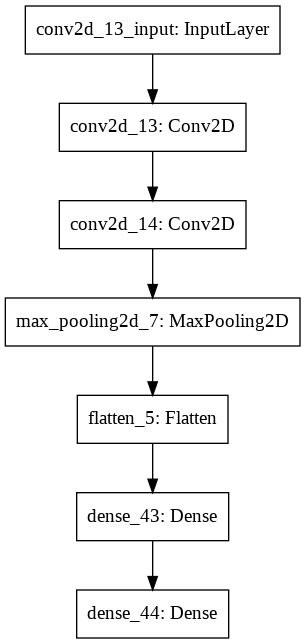

In [0]:
plot_model(model,to_file='model.png')

In [0]:
X_train_processed, Y_train_cat = preprocess(X_train,Y_train)
class_weights = compute_class_weight('balanced',classes = np.unique(Y_train),y = Y_train)

In [0]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(X_train_processed, Y_train_cat, batch_size=256, epochs=25, verbose=True, validation_split=.2,class_weight = class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 27839 samples, validate on 6960 samples
Epoch 1/25





27839/27839 [==============================] - 86s 3ms/step - loss: 1.6400 - acc: 0.5875 - val_loss: 0.4445 - val_acc: 0.8889
Epoch 2/25
27839/27839 [==============================] - 84s 3ms/step - loss: 0.2387 - acc: 0.9416 - val_loss: 0.1894 - val_acc: 0.9559
Epoch 3/25
27839/27839 [==============================] - 87s 3ms/step - loss: 0.1136 - acc: 0.9731 - val_loss: 0.1492 - val_acc: 0.9641
Epoch 4/25
27839/27839 [==============================] - 84s 3ms/step - loss: 0.0614 - acc: 0.9857 - val_loss: 0.1228 - val_acc: 0.9707
Epoch 5/25
27839/27839 [==============================] - 84s 3ms/step - loss: 0.0432 - acc: 0.9898 - val_loss: 0.1084 - val_acc: 0.9750
Epoch 6/25
27839/27839 [==============================] - 84s 3ms/step - loss: 0.0269 - acc: 0.9944 - val_loss: 0.1062 - val_acc: 0.9757
Epoch 7/25
27839/27839 [===

In [0]:
X_test_processed, Y_test_processed = preprocess(X_test,Y_test)

In [0]:
loss, accuracy  = model.evaluate(X_test_processed, Y_test_processed, verbose=False)

Test loss: 0.499
Test accuracy: 0.923


<Figure size 576x432 with 0 Axes>

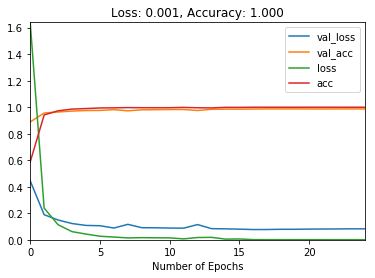

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_convnet():
  model = Sequential()
  
  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape = image_size))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))

  model.add(Conv2D(64, (3, 3), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))

  model.add(Dense(n_classes, activation='softmax'))
  
 
  return model
model = build_convnet()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)            

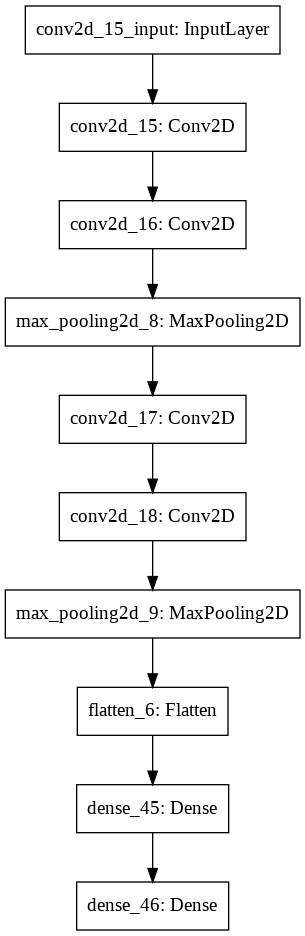

In [0]:
plot_model(model,to_file='model.png')

In [0]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_processed, Y_train_cat, batch_size=256, epochs=25, verbose=True, validation_split=.2,class_weight = class_weights)


Train on 27839 samples, validate on 6960 samples
Epoch 1/25
27839/27839 [==============================] - 136s 5ms/step - loss: 1.7359 - acc: 0.5392 - val_loss: 0.3327 - val_acc: 0.9003
Epoch 2/25
27839/27839 [==============================] - 136s 5ms/step - loss: 0.1500 - acc: 0.9592 - val_loss: 0.1259 - val_acc: 0.9687
Epoch 3/25
27839/27839 [==============================] - 135s 5ms/step - loss: 0.0674 - acc: 0.9820 - val_loss: 0.0762 - val_acc: 0.9828
Epoch 4/25
27839/27839 [==============================] - 135s 5ms/step - loss: 0.0333 - acc: 0.9913 - val_loss: 0.0792 - val_acc: 0.9830
Epoch 5/25
27839/27839 [==============================] - 135s 5ms/step - loss: 0.0208 - acc: 0.9945 - val_loss: 0.0634 - val_acc: 0.9856
Epoch 6/25
27839/27839 [==============================] - 134s 5ms/step - loss: 0.0164 - acc: 0.9960 - val_loss: 0.0596 - val_acc: 0.9882
Epoch 7/25
27839/27839 [==============================] - 136s 5ms/step - loss: 0.0094 - acc: 0.9979 - val_loss: 0.0642 - v

Test loss: 0.43
Test accuracy: 0.945


<Figure size 576x432 with 0 Axes>

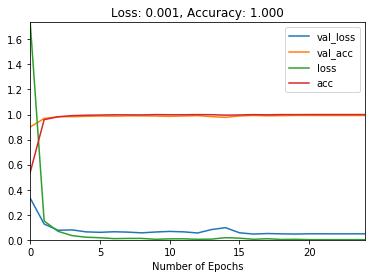

In [0]:
loss, accuracy  = model.evaluate(X_test_processed, Y_test_processed, verbose=False)
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_convnet():
  model = Sequential()
  
  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape = image_size))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(n_classes, activation='softmax'))
  
 
  return model
model = build_convnet()
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
___

In [0]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_processed, Y_train_cat, batch_size=256, epochs=25, verbose=True, validation_split=.2,class_weight = class_weights)

Train on 27839 samples, validate on 6960 samples
Epoch 1/25
27839/27839 [==============================] - 124s 4ms/step - loss: 2.3952 - acc: 0.3587 - val_loss: 0.6783 - val_acc: 0.8145
Epoch 2/25
27839/27839 [==============================] - 123s 4ms/step - loss: 0.5394 - acc: 0.8326 - val_loss: 0.1721 - val_acc: 0.9568
Epoch 3/25
27839/27839 [==============================] - 123s 4ms/step - loss: 0.2472 - acc: 0.9236 - val_loss: 0.0992 - val_acc: 0.9767
Epoch 4/25
27839/27839 [==============================] - 123s 4ms/step - loss: 0.1582 - acc: 0.9506 - val_loss: 0.0649 - val_acc: 0.9848
Epoch 5/25
27839/27839 [==============================] - 123s 4ms/step - loss: 0.1079 - acc: 0.9659 - val_loss: 0.0462 - val_acc: 0.9897
Epoch 6/25
27839/27839 [==============================] - 123s 4ms/step - loss: 0.0810 - acc: 0.9737 - val_loss: 0.0398 - val_acc: 0.9905
Epoch 7/25
27839/27839 [==============================] - 123s 4ms/step - loss: 0.0708 - acc: 0.9772 - val_loss: 0.0333 - v

Test loss: 0.189
Test accuracy: 0.964


<Figure size 576x432 with 0 Axes>

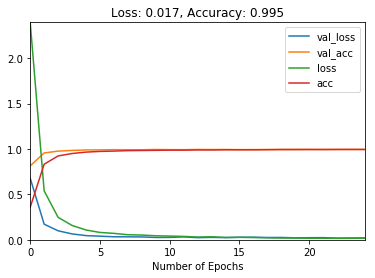

In [0]:
loss, accuracy  = model.evaluate(X_test_processed, Y_test_processed, verbose=False)
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
y_prob = model.predict(X_test_processed) 
y_classes = y_prob.argmax(axis=-1)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


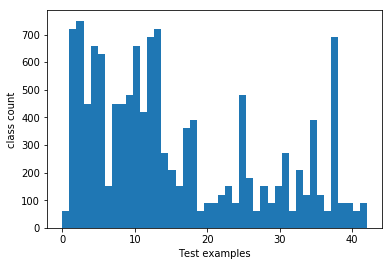

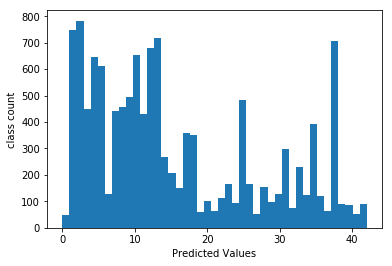

In [0]:
show_hist(Y_test, "Test examples")
show_hist(y_classes, "Predicted Values")

In [0]:
from sklearn.metrics import classification_report
Y_test_class = np.argmax(Y_test_processed, axis=1)
y_pred = model.predict_classes(X_test_processed)
print(classification_report(Y_test_class, y_pred))

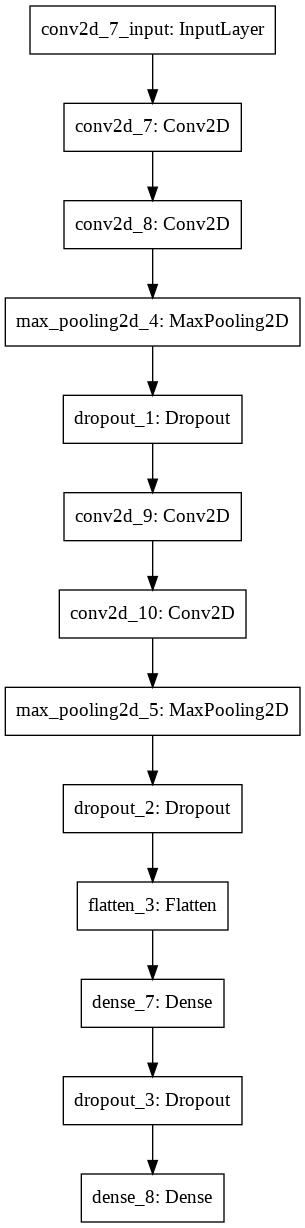

In [0]:
from keras.utils import plot_model
plot_model(model,to_file='model.png')